# 06 — Time-series validation and robustness checks

This notebook performs a walk-forward (TimeSeriesSplit) validation on the engineered feature set, compares baseline and benchmark models, and summarizes the stability of results (XLE, ICLN). Outputs include fold-level metrics and summary tables saved to disk.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

pd.set_option("display.float_format", lambda x: f"{x:.6f}")

project_root = Path("..")

data_dir = project_root / "data"
outputs_dir = project_root / "outputs"
plots_dir = outputs_dir / "plots"
results_dir = outputs_dir / "results"

r2_timeseries_dir = plots_dir / "r2_timeseries"

plots_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)
r2_timeseries_dir.mkdir(parents=True, exist_ok=True)

In [2]:
features_path = data_dir / "model_features_2018_2024.parquet"
assert features_path.exists(), f"Missing file: {features_path}"

data = pd.read_parquet(features_path)

print("Dataset shape:", data.shape)
data.head()

Dataset shape: (1738, 35)


,WTI_ret_lag1,WTI_ret_lag2,WTI_ret_lag3,WTI_ret_lag5,WTI_ret_lag10,XLE_ret_lag1,XLE_ret_lag2,XLE_ret_lag3,XLE_ret_lag5,XLE_ret_lag10,...,XLE_rollmean_20d,XLE_rollstd_20d,ICLN_rollmean_5d,ICLN_rollstd_5d,ICLN_rollmean_10d,ICLN_rollstd_10d,ICLN_rollmean_20d,ICLN_rollstd_20d,XLE_target,ICLN_target
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-31,-0.016300,-0.008808,0.009571,0.017528,0.003759,-0.020379,-0.015210,0.005434,-0.002699,0.008727,...,0.000944,0.011001,0.000209,0.002264,-0.001143,0.003194,0.000578,0.006702,0.010235,-0.005238
2018-02-01,0.003560,-0.016300,-0.008808,-0.001525,-0.000313,0.000668,-0.020379,-0.015210,-0.007882,-0.008204,...,0.000713,0.010739,-0.001465,0.002628,-0.000941,0.002805,0.000422,0.006803,-0.042686,-0.022306
2018-02-02,0.016395,0.003560,-0.016300,0.009571,-0.009111,0.010235,0.000668,-0.020379,0.005434,-0.001309,...,-0.001723,0.014378,-0.005926,0.009491,-0.003379,0.007139,-0.000321,0.008345,-0.042859,-0.031645
2018-02-05,-0.005333,0.016395,0.003560,-0.008808,0.001892,-0.042686,0.010235,0.000668,-0.015210,0.021372,...,-0.003846,0.017057,-0.011629,0.014589,-0.006544,0.011284,-0.002063,0.010836,0.007891,0.008830
2018-02-06,-0.020062,-0.005333,0.016395,-0.016300,0.015318,-0.042859,-0.042686,0.010235,-0.020379,-0.001539,...,-0.003750,0.017120,-0.009863,0.016726,-0.005349,0.012276,-0.002361,0.010423,-0.016863,-0.005510


In [3]:
target_cols = ["XLE_target", "ICLN_target"]

exclude_cols = set(target_cols)
for c in ["Date", "date", "timestamp"]:
    if c in data.columns:
        exclude_cols.add(c)

feature_cols = [c for c in data.columns if c not in exclude_cols]

X = data[feature_cols].copy()
y = data[target_cols].copy()

# Basic sanity checks
assert all(c in data.columns for c in target_cols), f"Missing targets: {set(target_cols) - set(data.columns)}"
assert len(X) == len(y) == len(data)

# If a date column exists, enforce chronological order
date_col = next((c for c in ["Date", "date", "timestamp"] if c in data.columns), None)
if date_col is not None:
    assert data[date_col].is_monotonic_increasing, f"{date_col} is not sorted increasing"

train_frac = 0.80
train_size = int(len(data) * train_frac)

X_train, y_train = X.iloc[:train_size].copy(), y.iloc[:train_size].copy()
X_test,  y_test  = X.iloc[train_size:].copy(), y.iloc[train_size:].copy()

print("Total observations:", len(data))
print("Train size:", len(X_train))
print("Test size:", len(X_test))

Total observations: 1738
Train size: 1390
Test size: 348


In [4]:
def compute_metrics(y_true, y_pred) -> dict:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    return {
        "n": int(len(y_true)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

In [5]:
n_splits = 5
test_size = len(X_train) // (n_splits + 1)  # stable fold sizes

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

results = []
targets = target_cols

for split_id, (train_idx, val_idx) in enumerate(tscv.split(X_train), start=1):
    X_tr = X_train.iloc[train_idx]
    X_val = X_train.iloc[val_idx]

    print(f"Split {split_id}: train={len(train_idx)}, val={len(val_idx)}")

    for target in targets:
        y_tr = y_train[target].iloc[train_idx]
        y_val = y_train[target].iloc[val_idx]

        # Naive benchmark: zero return
        y_pred_naive = np.zeros(len(y_val))

        lr_pipeline = Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("model", LinearRegression()),
            ]
        )
        lr_pipeline.fit(X_tr, y_tr)
        y_pred_lr = lr_pipeline.predict(X_val)

        rf_model = RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
        )
        rf_model.fit(X_tr, y_tr)
        y_pred_rf = rf_model.predict(X_val)

        for model_name, y_pred in [
            ("naive", y_pred_naive),
            ("linear_regression", y_pred_lr),
            ("random_forest", y_pred_rf),
        ]:
            metrics = compute_metrics(y_val, y_pred)
            metrics["split"] = split_id
            metrics["target"] = target
            metrics["model"] = model_name
            results.append(metrics)

cv_results = pd.DataFrame(results)[
    ["split", "target", "model", "n", "RMSE", "MAE", "R2"]
]

cv_results.head()

Split 1: train=235, val=231


Split 2: train=466, val=231
Split 3: train=697, val=231
Split 4: train=928, val=231
Split 5: train=1159, val=231


,split,target,model,n,RMSE,MAE,R2
0,1,XLE_target,naive,231,0.011996,0.009372,-0.000000
1,1,XLE_target,linear_regression,231,0.015866,0.012240,-0.749261
2,1,XLE_target,random_forest,231,0.012573,0.009809,-0.098493
3,1,ICLN_target,naive,231,0.009513,0.007366,-0.014795
4,1,ICLN_target,linear_regression,231,0.013025,0.009943,-0.902292


In [7]:
cv_summary = (
    cv_results
    .groupby(["target", "model"], as_index=False)
    .agg(
        mean_n=("n", "mean"),
        mean_RMSE=("RMSE", "mean"),
        std_RMSE=("RMSE", "std"),
        mean_MAE=("MAE", "mean"),
        std_MAE=("MAE", "std"),
        mean_R2=("R2", "mean"),
        std_R2=("R2", "std"),
    )
)

cv_summary

,target,model,mean_n,mean_RMSE,std_RMSE,mean_MAE,std_MAE,mean_R2,std_R2
0,ICLN_target,linear_regression,231.000000,0.021453,0.007433,0.015337,0.003926,-0.296102,0.360677
1,ICLN_target,naive,231.000000,0.019445,0.007016,0.014151,0.004420,-0.006826,0.006722
2,ICLN_target,random_forest,231.000000,0.019902,0.007103,0.014537,0.004537,-0.058645,0.021341
3,XLE_target,linear_regression,231.000000,0.024926,0.010035,0.018042,0.005346,-0.342568,0.309667
4,XLE_target,naive,231.000000,0.022135,0.009947,0.016151,0.005543,-0.004989,0.005878
5,XLE_target,random_forest,231.000000,0.023999,0.010310,0.017231,0.005860,-0.192473,0.177689


In [8]:
cv_results_path = results_dir / "cv_results_timeseries.csv"
cv_summary_path = results_dir / "cv_summary_timeseries.csv"

cv_results.to_csv(cv_results_path, index=False)
cv_summary.to_csv(cv_summary_path, index=False)

cv_results_path, cv_summary_path

(PosixPath('../outputs/results/cv_results_timeseries.csv'),
 PosixPath('../outputs/results/cv_summary_timeseries.csv'))

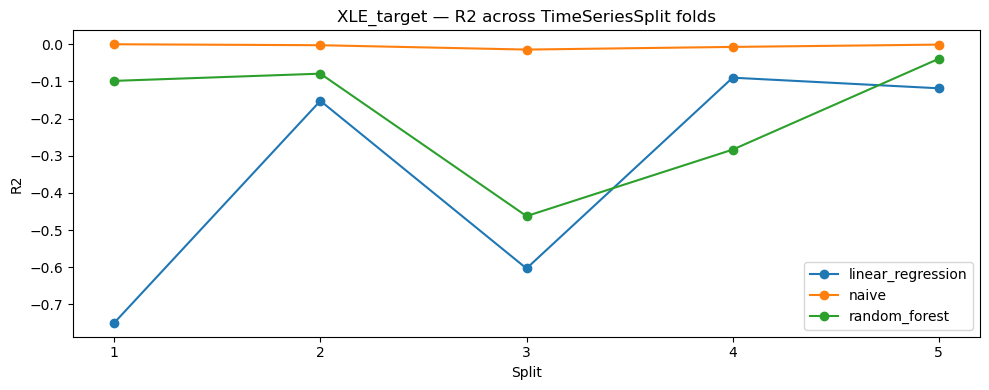

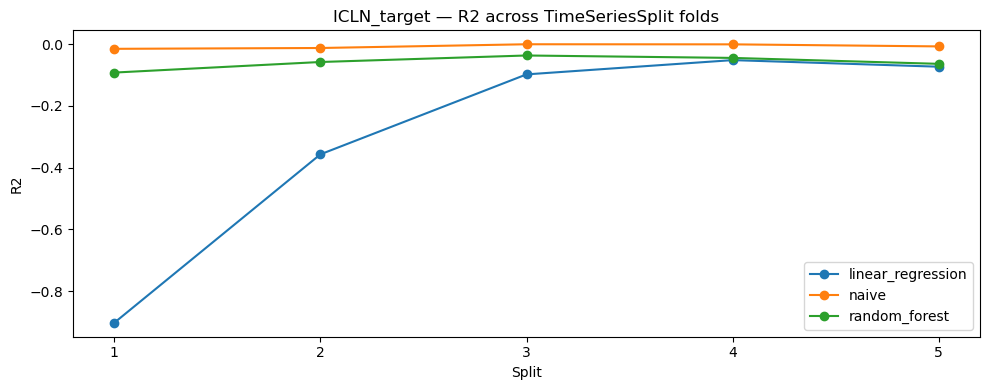

In [9]:
for target in target_cols:
    subset = cv_results[cv_results["target"] == target].sort_values(["model", "split"])

    fig, ax = plt.subplots(figsize=(10, 4))

    for model_name in subset["model"].unique():
        model_data = subset[subset["model"] == model_name].sort_values("split")
        ax.plot(model_data["split"], model_data["R2"], marker="o", label=model_name)

    ax.set_title(f"{target} — R2 across TimeSeriesSplit folds")
    ax.set_xlabel("Split")
    ax.set_ylabel("R2")
    ax.set_xticks(sorted(subset["split"].unique()))
    ax.legend()

    plt.tight_layout()
    save_path = r2_timeseries_dir / f"r2_timeseries_{target}.png"
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()

## Interpretation

We compare fold-level and average out-of-sample metrics (RMSE, MAE, R²) for the naive baseline, Linear Regression, and Random Forest on XLE and ICLN. The main focus is (i) whether any model consistently improves over the baseline, and (ii) how stable performance is across time splits. Results should be interpreted as predictive stability checks on the chosen feature set rather than evidence of structural predictability.